In [1]:
import numpy as np
from matplotlib import pyplot as plt
%run 'parse.ipynb'
%matplotlib inline

In [2]:
s1 = parse(subj=1)
s2 = parse(subj=2)

In [ ]:
C = s1['Pre_RS'].as_matrix()[1:, 1:]
n_clusters = 10
n_variables = 278
cluster_size = n_variables/n_clusters
#rs2 = s1['Pre_RS'].as_matrix()[1:, 1:]

def score(C):
    '''
    Function to assign a score to an ordered covariance matrix.
    High correlations within a cluster improve the score.
    High correlations between clusters decease the score.
    '''
    score = 0
    for cluster in range(n_clusters):
        inside_cluster = np.arange(cluster_size) + cluster * cluster_size
        outside_cluster = np.setdiff1d(range(n_variables), inside_cluster)

        # Belonging to the same cluster
        score += np.sum(C[inside_cluster, :][:, inside_cluster])

        # Belonging to different clusters
        score -= np.sum(C[inside_cluster, :][:, outside_cluster])
        score -= np.sum(C[outside_cluster, :][:, inside_cluster])

    return score


initial_C = C
initial_score = score(C)
initial_ordering = np.arange(n_variables)

plt.figure()
plt.imshow(C, interpolation='nearest')
plt.title('Initial C')
print 'Initial ordering:', initial_ordering
print 'Initial covariance matrix score:', initial_score

# Pretty dumb greedy optimization algorithm that continuously
# swaps rows to improve the score
def swap_rows(C, var1, var2):
    '''
    Function to swap two rows in a covariance matrix,
    updating the appropriate columns as well.
    '''
    D = C.copy()
    D[var2, :] = C[var1, :]
    D[var1, :] = C[var2, :]

    E = D.copy()
    E[:, var2] = D[:, var1]
    E[:, var1] = D[:, var2]

    return E

current_C = C
current_ordering = initial_ordering
current_score = initial_score

max_iter = 1000
for i in range(max_iter):
    # Find the best row swap to make
    best_C = current_C
    best_ordering = current_ordering
    best_score = current_score
    for row1 in range(n_variables):
        for row2 in range(n_variables):
            if row1 == row2:
                continue
            option_ordering = best_ordering.copy()
            option_ordering[row1] = best_ordering[row2]
            option_ordering[row2] = best_ordering[row1]
            option_C = swap_rows(best_C, row1, row2)
            option_score = score(option_C)

            if option_score > best_score:
                best_C = option_C
                best_ordering = option_ordering
                best_score = option_score

    if best_score > current_score:
        # Perform the best row swap
        current_C = best_C
        current_ordering = best_ordering
        current_score = best_score
    else:
        # No row swap found that improves the solution, we're done
        break

# Output the result
plt.figure()
plt.imshow(current_C, interpolation='nearest')
plt.title('Best C')
print 'Best ordering:', current_ordering
print 'Best score:', current_score
print
print 'Cluster     [variables assigned to this cluster]'
print '------------------------------------------------'
for cluster in range(n_clusters):
    print 'Cluster %02d  %s' % (cluster + 1, current_ordering[cluster*cluster_size:(cluster+1)*cluster_size])
    

Initial ordering: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 

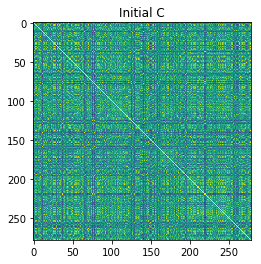

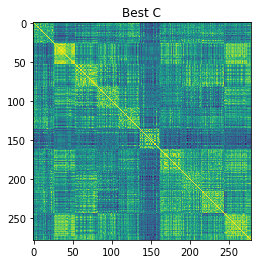

In [6]:
import random
class solver:
    def __init__(self, G, delta = 1.0/44):
        """
        Args:
            delta: "cleanness" parameter. Defaults to the assumed value of 1/44
                   given in the paper
        """

        self.__G__ = G
        self.__reset_caches__()
        self.__clusters__ = None
        self.__delta__ = delta

    def __reset_caches__(self):
        self.__G_nodes__ = set(self.__G__.nodes())
        self.__N_plus_cache__ = dict()

    def __remove_cluster__(self, C):
        self.__G__.remove_nodes_from(C)
        self.__reset_caches__()

    def positive_neighbours(self, u):
        """
        Returns N+(u), or {u} U {v : e(u, v) = +}

        Args:
            G: a networkx graph where presence of edges indicates a + edge
            u: a node in G
        """

        if u in self.__N_plus_cache__:
            return self.__N_plus_cache__[u]

        res = set([u])
        for i in self.__G__.neighbors(u):
            res.add(i)

        self.__N_plus_cache__[u] = res
        return res

    def delta_good(self, v, C, delta):
        """
        Returns true if v is delta-good with respect to C, where C is a cluster in
        G

        Args:
            G: a networkx graph
            v: a vertex v in G
            C: a set of vertices in G
            delta: "cleanness" parameter
        """

        Nv = self.positive_neighbours(v)

        return (len(Nv & C) >= (1.0 - delta) * len(C) and
                len(Nv & (self.__G_nodes__ - C)) <= delta * len(C))

    def run(self):
        """
        Runs the "cautious algorithm" from the paper.

        """

        if self.__clusters__ is None:
            self.__clusters__ = []
            
            while len(self.__G_nodes__) > 0:
                # Make sure we try all the vertices until we run out
                vs = random.sample(self.__G_nodes__, len(self.__G_nodes__))

                Av = None

                for v in vs:
                    Av = self.positive_neighbours(v).copy()

                    # Vertex removal step
                    for x in self.positive_neighbours(v):
                        if not self.delta_good(x, Av, 3 * self.__delta__):
                            Av.remove(x)

                    # Vertex addition step
                    Y = set(y for y in self.__G_nodes__
                              if self.delta_good(y, Av, 7 * self.__delta__))
                    Av = Av | Y

                    if len(Av) > 0:
                        break

                # Second quit condition: all sets Av are empty
                if len(Av) == 0:
                    break

                self.__clusters__.append(Av)
                self.__remove_cluster__(Av)

            # add all remaining vertices as singleton clusters
            for v in self.__G_nodes__:
                self.__clusters__.append(set([v]))

        return self.__clusters__